# Single Raw Aspect Modelling

In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [68]:
PATH    = "./../data/single_raw.csv"

In [69]:
data = pd.read_csv(PATH, usecols=["ProductId", "Score", "Text"])

In [70]:
data.head()

,ProductId,Score,Text
0,0,1,advertise product arrive label jumbo salt pean...
1,1,4,delight say confection around century light pi...
2,2,4,nice taffy get wild hair taffy order five poun...
3,4,5,strawberry twizzler yummy strawberry twizzler ...
4,4,5,lot twizzler expect daughter love twizzler shi...


In [71]:
# Return matrix of tfidf for each configuration of documents (rows) and words (columns)
vectorizer  = TfidfVectorizer()
word_sparse = vectorizer.fit_transform(data["Text"])

In [72]:
product_ids = data["ProductId"].values.reshape(-1,1)
product_ids_sparse = csr_matrix(product_ids)

In [73]:
x = hstack([product_ids, word_sparse])
y = data["Score"].values - 1

In [74]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42
)

In [75]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(83397, 52006)
(83397,)
(20850, 52006)
(20850,)


## Neural Network Classifier

In [76]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 5

epoch_no    = 100
batch_size  = 512

In [77]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [78]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Add layers and activation function to neural network
nn_class    = tf.keras.Sequential()

nn_class.add(Input(shape=(input_dim,)))
nn_class.add(Dense(n_neurons_1, activation='relu'))
nn_class.add(Dense(n_neurons_2, activation='relu'))
nn_class.add(Dense(n_neurons_3, activation='relu'))
nn_class.add(Dense(output_dim, activation='sigmoid'))

# Configure loss function, gradient descent, and evaluation metrics
nn_class.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
nn_class.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 272ms/step - accuracy: 0.4388 - loss: 25.4501
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 271ms/step - accuracy: 0.5922 - loss: 1.8737
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 266ms/step - accuracy: 0.5754 - loss: 2.0171
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 266ms/step - accuracy: 0.6407 - loss: 1.5187
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 269ms/step - accuracy: 0.5943 - loss: 1.4475
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 271ms/step - accuracy: 0.6584 - loss: 1.1225
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 267ms/step - accuracy: 0.6613 - loss: 1.0896
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 264ms/step - accuracy: 0.6452 - loss: 1.1422
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.6512 - loss: 1.1557
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 279ms/step - accuracy: 0.6592 - loss: 1.1137
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 300ms/step - accuracy: 0.6533 - loss: 1.1013
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 302ms/step - accuracy: 0.6568 - loss: 1.0938
Epoch 13/100
163/16

## Neural Network Regressor

In [101]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 1

epoch_no    = 100
batch_size  = 512

In [102]:
# Add layers and activation function to neural network
nn_reg    = tf.keras.Sequential()

nn_reg.add(Input(shape=(input_dim,)))
nn_reg.add(Dense(n_neurons_1, activation='relu'))
nn_reg.add(Dense(n_neurons_2, activation='relu'))
nn_reg.add(Dense(n_neurons_3, activation='relu'))
nn_reg.add(Dense(output_dim, activation='linear'))

# Configure loss function, gradient descent, and evaluation metrics
nn_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

In [103]:
reg_loss = nn_reg.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 428ms/step - loss: 367.8365 - mae: 9.1239
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 412ms/step - loss: 4.8319 - mae: 1.8634
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 418ms/step - loss: 5.9227 - mae: 2.0067
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 411ms/step - loss: 7.2108 - mae: 2.0897
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - loss: 2.6638 - mae: 1.3558
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 440ms/step - loss: 8.2518 - mae: 1.9425
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 442ms/step - loss: 7.8296 - mae: 2.1498
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 413ms/step - loss: 2.8902 - mae: 1.4195
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - loss: 2.5427 - mae: 1.3296
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - loss: 2.3715 - mae: 1.2816
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 340ms/step - loss: 2.1160 - mae: 1.2149
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 332ms/step - loss: 1.9780 - mae: 1.1745
Epoch 13/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 329ms/step - loss: 1.8178 - 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC

652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1.2404584884643555


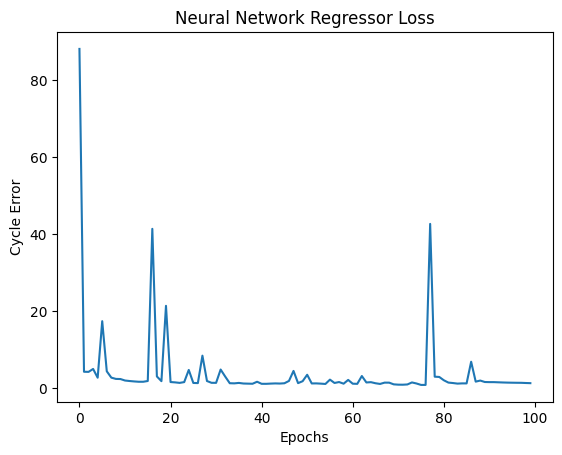

In [104]:
# Neural Network Regression MSE
nn_pred = nn_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=nn_pred))

plt.plot(reg_loss.history['loss'])
plt.title("Neural Network Regressor Loss")
plt.xlabel("Epochs")
plt.ylabel("Cycle Error")
plt.show()

652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
              precision    recall  f1-score   support

           0       0.55      0.50      0.52      1999
           1       0.20      0.00      0.00      1126
           2       0.67      0.00      0.00      1415
           3       0.43      0.00      0.00      2738
           4       0.71      1.00      0.83     13572

    accuracy                           0.70     20850
   macro avg       0.51      0.30      0.27     20850
weighted avg       0.63      0.70      0.59     20850



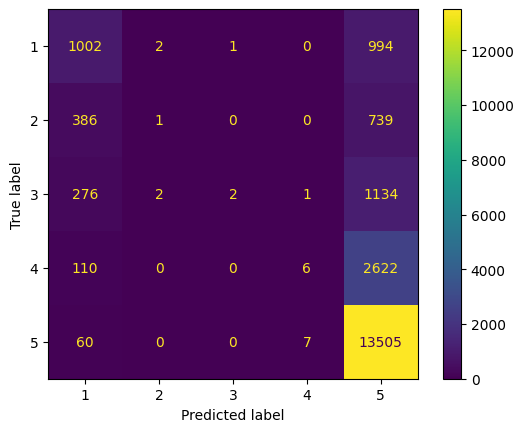

In [ ]:
# Neural Network Classification
nn_pred = nn_class.predict(x_test)
nn_pred = [np.argmax(arr) for arr in nn_pred]
print(classification_report(y_pred=nn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.show()

In [ ]:
# Support Vector Machine Classification
svc = SVC(kernel='rbf')
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
print(classification_report(y_pred=svc_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1999
           1       0.00      0.00      0.00      1126
           2       0.00      0.00      0.00      1415
           3       0.00      0.00      0.00      2738
           4       0.65      1.00      0.79     13572

    accuracy                           0.65     20850
   macro avg       0.13      0.20      0.16     20850
weighted avg       0.42      0.65      0.51     20850



c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


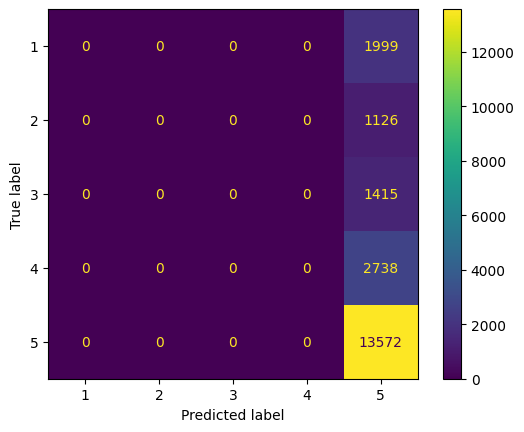

In [96]:
# Plot the confusion matrix of the SVM model
cm = confusion_matrix(y_true=y_test, y_pred=svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1","2","3","4","5"])

disp.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.37      0.50      1999
           1       0.89      0.14      0.24      1126
           2       0.85      0.14      0.24      1415
           3       0.85      0.14      0.24      2738
           4       0.71      1.00      0.83     13572

    accuracy                           0.72     20850
   macro avg       0.81      0.36      0.41     20850
weighted avg       0.75      0.72      0.65     20850



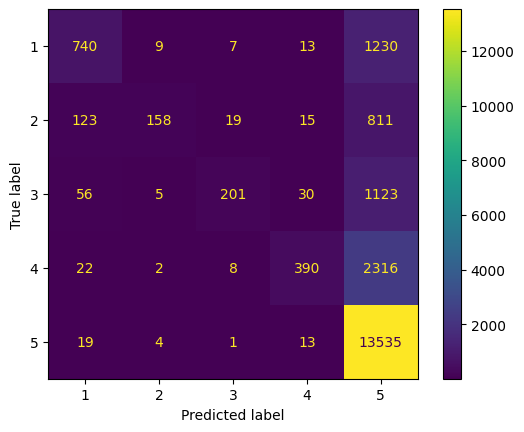

In [100]:
# Random Forest Classficication
rf = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=2)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_pred=rf_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.show()